In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import moscot
from anndata import AnnData
import numpy as np
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver, LRSinkhornSolver
from moscot.solvers._data import TaggedArray, Tag
import matplotlib.pyplot as plt
import jax.numpy as jnp
from typing import *
import pandas as pd
import networkx as nx
import jax.numpy as jnp
from moscot.problems.time._lineage import TemporalProblem
import os
import wot
from functools import partial

In [3]:
import scanpy as sc
import matplotlib as mpl

In [4]:
import ott
import ot
from tqdm import tqdm

In [5]:
data_path = "/home/icb/dominik.klein/data/wot"


VAR_GENE_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
SERUM_CELL_IDS_PATH = os.path.join(data_path, 'serum_cell_ids.txt')
CELL_GROWTH_PATH = os.path.join(data_path, 'growth_gs_init.txt')
FULL_DS_PATH = os.path.join(data_path, 'ExprMatrix.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
VAR_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
TMAP_PATH = os.path.join(data_path, 'serum')
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
COORDS_PATH = os.path.join(data_path, 'fle_coords.txt')

In [6]:
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

In [7]:
sc.tl.pca(adata)

In [8]:
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
cell_to_type = {v[i]: k for k, v in cell_sets.items() for i in range(len(v))}
df_cell_type = pd.DataFrame(cell_to_type.items(), columns=["0", "cell_type"]).set_index("0")
adata.obs = pd.merge(adata.obs, df_cell_type, how="left", left_index=True, right_index=True)

In [9]:
days = list(adata.obs.day.unique())
days.pop(-1) # remove nan

nan

## Run WOT

In [10]:
#ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

In [11]:
#tmap_annotated = ot_model.compute_transport_map(11,11.5)

## Run Moscot

In [12]:
tp = TemporalProblem(adata, solver=SinkhornSolver(jit=False))

In [13]:
adata.obs.day = adata.obs.day.astype('category')

In [14]:
tp.prepare("day", x={"attr": "obsm", "key": "X_pca"}, y={"attr": "obsm", "key": "X_pca"}, a_marg={"attr": "obs", "key":"cell_growth_rate"})

In [15]:
lambda_1 = 1.0
#lambda_2 = 50.0
eps = 5.0
tp.solve(eps=eps, tau_a=lambda_1/(lambda_1+eps), tau_b=1)

2022-02-03 09:17:31.327317: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB (rounded to 3142728960)requested by op 
2022-02-03 09:17:31.327956: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:474] ***_________________________________________________________________________________________________
2022-02-03 09:17:31.328280: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3142728800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.53MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.93GiB
     preallocated temp allocation:         0B
                 total allocation:    2.93GiB
              total fragmentation:         0B (0.00%)
Peak buffe

RuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3142728800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.53MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.93GiB
     preallocated temp allocation:         0B
                 total allocation:    2.93GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.93GiB
		Operator: op_type="mul" op_name="jit(vmap(vmap(fn)))/mul" source_file="/mnt/home/icb/dominik.klein/git_repos/ott/ott/ott/geometry/costs.py" source_line=30
		XLA Label: fusion
		Shape: f32[3449,4556,50]
		==========================

	Buffer 2:
		Size: 889.8KiB
		Entry Parameter Subshape: f32[4556,50]
		==========================

	Buffer 3:
		Size: 673.6KiB
		Entry Parameter Subshape: f32[3449,50]
		==========================



## Pull back mass

In [14]:
adata[adata.obs.day==18.0].obs.cell_type.value_counts(dropna=False)

Stromal        1239
Neural          819
NaN             534
Epithelial      503
IPS             412
Trophoblast     292
Name: cell_type, dtype: int64

In [15]:
adata[adata.obs.day==18.0]

View of AnnData object with n_obs × n_vars = 3799 × 1479
    obs: 'day', 'cell_growth_rate', 'cell_type'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [16]:
#for i in range(38):
#    print(adata.uns[f"cost_matrix_{i}"].shape)

In [17]:
result = tp.pull_back_composed(start=0, end=18, key_groups="cell_type", groups=["IPS"], return_all=True)

3799 3799
(3799, 1) 1.0 (array([0.        , 0.00242718]), array([3387,  412]))
3799 3799
(4068, 1) 0.0002632272
4068 4068
(3678, 1) 0.00024582105
3678 3678
(4645, 1) 0.00027188694
4645 4645
(3422, 1) 0.00021528533
3422 3422
(4851, 1) 0.0002922266
4851 4851
(3717, 1) 0.00020614304
3717 3717
(2723, 1) 0.00026903412
2723 2723
(3758, 1) 0.000367242
3758 3758
(2034, 1) 0.00026609912
2034 2034
(2145, 1) 0.0004916419
2145 2145
(2253, 1) 0.00046620087
2253 2253
(2429, 1) 0.00044385274
2429 2429
(2164, 1) 0.0004116913
2164 2164
(2238, 1) 0.00046210742
2238 2238
(1941, 1) 0.00044682767
1941 1941
(2051, 1) 0.00051519764
2051 2051
(2266, 1) 0.00048756716
2266 2266
(2982, 1) 0.0004413058
2982 2982
(3088, 1) 0.00033534493
3088 3088
(3573, 1) 0.00032383407
3573 3573
(3829, 1) 0.00027987687
3829 3829
(3815, 1) 0.00026116506
3815 3815
(5061, 1) 0.00026212353
5061 5061
(6507, 1) 0.00019758931
6507 6507
(3111, 1) 0.00015368077
3111 3111
(8422, 1) 0.00032143993
8422 8422
(6550, 1) 0.000118736505
6550 6550

In [29]:
np.quantile(result[0], 0.9)

0.0024271844660194173

In [31]:
result[0].max() > 1e-3

True

In [27]:
r_scaled = []
for r in result:
    r_min = r.min()
    r_max = r.max()
    r_scaled.append((r - r_min)/(r_max - r_min))

In [28]:
result = r_scaled

## Compare

In [33]:
COORD_DF = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)

In [34]:
nbins = 500
xrange = COORD_DF['x'].min(), COORD_DF['x'].max()
yrange = COORD_DF['y'].min(), COORD_DF['y'].max()
COORD_DF['x'] = np.floor(
    np.interp(COORD_DF['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
COORD_DF['y'] = np.floor(
    np.interp(COORD_DF['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)

In [35]:
bdata = adata.copy()
bdata.obs = bdata.obs.join(COORD_DF)

In [71]:
np.percentile(result[1], [90,80])

array([2.08434427e-08, 5.79137196e-36])

In [79]:
percentile_thresholds = [90, 80]
alpha_bins = np.linspace(0,1,len(percentile_thresholds)+1)

def bin_alpha(x, thresholds):
    if x >= thresholds[0]:
        return alpha_bins[0]
    elif x >= thresholds[1]:
        return alpha_bins[1]
    return alpha_bins[2]
days_reverse = days[::-1]
bdata.obs["alpha_bin"] = np.nan
for i in tqdm(range(len(result))):
    bdata_filtered = bdata[bdata.obs.day==days_reverse[i]]
    assert len(bdata_filtered) == len(result[i])
    thresholds = np.percentile(result[i], percentile_thresholds)+1e-8
    bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"] = list(map(partial(bin_alpha, thresholds=thresholds), result[i]))

100%|██████████| 39/39 [01:45<00:00,  2.70s/it]


In [80]:
bdata.obs.alpha_bin.value_counts()

0.0    158604
1.0      6542
0.5       746
Name: alpha_bin, dtype: int64

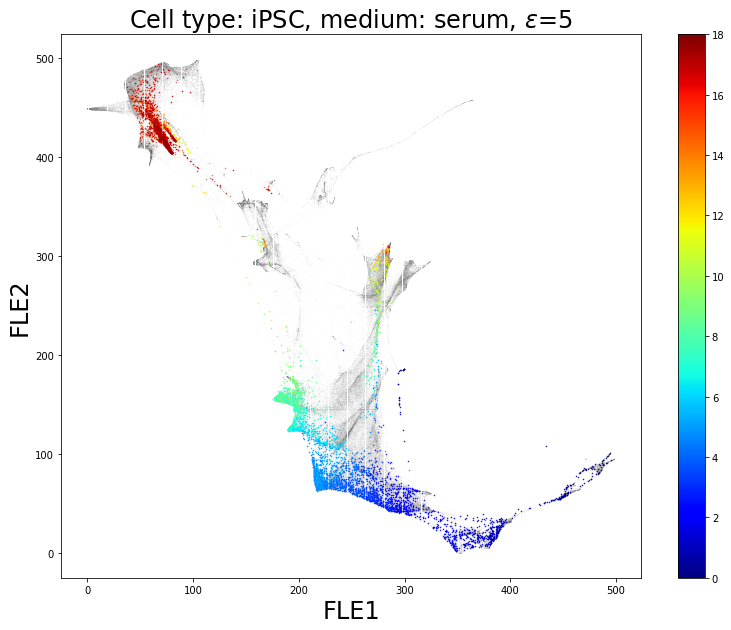

In [81]:
cm = plt.get_cmap('jet')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(result))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(13, 10))
plt.title(f'Cell type: iPSC, medium: serum, $\epsilon$={5}', fontsize=24)
plt.plot(COORD_DF['x'], COORD_DF['y'], marker='.', color='grey', ls='',
         markersize=0.3, alpha=0.07)
for i in range(len(result)):
    colorVal = scalarMap.to_rgba(i)
    for b in alpha_bins:
        colorVal = np.array(colorVal)
        colorVal[3] = b
        plt.plot(bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "x"],
                 bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "y"],
               marker='.', color=colorVal, ls='', markersize=1)
plt.xlabel('FLE1', fontsize=24)
plt.ylabel('FLE2', fontsize=24)
ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cm,
                       norm=mpl.colors.Normalize(vmin=0, vmax=18))
plt.show()

In [48]:
tp._problems[(0.0, 0.5)]._x

TaggedArray(data=ArrayView([[17.114956  ,  0.5369539 , 10.336855  , ...,  0.07194051,
             0.99540997, -1.0624027 ],
           [15.916597  ,  1.7973834 , 10.947183  , ...,  0.32980183,
            -1.1482922 , -0.6225205 ],
           [17.13795   ,  4.4078274 , 10.783276  , ..., -0.90465564,
             1.6393702 , -0.10279357],
           ...,
           [15.205801  ,  1.4775448 ,  9.589125  , ..., -2.4271271 ,
            -3.0371497 ,  0.25582048],
           [17.59106   ,  2.8553543 , 10.132644  , ..., -1.1579766 ,
             1.1985185 , -1.575386  ],
           [20.217102  , -0.71681786, 10.766388  , ...,  1.9845254 ,
             2.8097603 , -0.7642432 ]], dtype=float32), tag=<Tag.POINT_CLOUD: 3>, loss=<ott.geometry.costs.Euclidean object at 0x7f5908873b50>)

In [63]:
dir(tp.solution[(0.0, 0.5)]._output.geom)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply_cost',
 '_apply_cost_to_vec',
 '_apply_transport_from_potentials',
 '_apply_transport_from_scalings',
 '_axis_norm',
 '_center',
 '_cost_fn',
 '_cost_matrix',
 '_epsilon',
 '_epsilon_init',
 '_kernel_matrix',
 '_kwargs',
 '_norm_x',
 '_norm_y',
 '_online',
 '_relative_epsilon',
 '_scale',
 '_softmax',
 'apply_cost',
 'apply_cost_1',
 'apply_cost_2',
 'apply_kernel',
 'apply_lse_kernel',
 'apply_square_cost',
 'apply_transport_from_potentials',
 'apply_transport_from_scalings',
 'copy_epsilon',
 'cost_matrix',
 'cost_rank',
 'epsilon',
 'is_online',
 'is_squared_euclidean',
 'is_symmetric',
 'kernel_matrix',
 'marg

In [67]:
tp.solution[(0.0, 0.5)]._output.geom.is_online

True